In [ ]:
!pip install pickle5
!pip install --upgrade pandas

In [3]:
import os
import pickle5 as pickle
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Dropout
from tensorflow.keras import optimizers

import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

print(f'tensorflow version: {tf.version.VERSION}')

tensorflow version: 2.7.0


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# set seed, debugging and assign GPU

tf.random.set_seed(50)
tf.debugging.set_log_device_placement(False)

tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [10]:
# import data

with open('/content/drive/MyDrive/Thesis/usa_classified_tweets.pkl', 'rb') as pickle_in:
  df = pickle.load(pickle_in)
  pickle_in.close()

In [11]:
df['believer_denier'].value_counts()

1    114667
0     36131
Name: believer_denier, dtype: int64

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150798 entries, 0 to 150797
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   150798 non-null  int64  
 1   text                 150798 non-null  object 
 2   location             150798 non-null  object 
 3   total_pop            150798 non-null  float64
 4   women                150798 non-null  float64
 5   hispanic             150798 non-null  float64
 6   white                150798 non-null  float64
 7   black                150798 non-null  float64
 8   native               150798 non-null  float64
 9   asian                150798 non-null  float64
 10  pacific              150798 non-null  float64
 11  income_per_cap       150798 non-null  float64
 12  poverty              150798 non-null  float64
 13  unemployment         150798 non-null  float64
 14  democrats            150798 non-null  float64
 15  republicans      

In [13]:
# drop unnecessary variables

df = df.drop(columns=['id', 'text', 'location', 'total_pop', 'republicans'])

In [14]:
# check if there are no NA's

df.isna().sum()

women                  0
hispanic               0
white                  0
black                  0
native                 0
asian                  0
pacific                0
income_per_cap         0
poverty                0
unemployment           0
democrats              0
voting_age_citizens    0
believer_denier        0
dtype: int64

In [15]:
# assign X and y 

X = df.drop('believer_denier', axis=1)
y = df['believer_denier']

# resample data with Random OverSampler to deal with class imbalance
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X, y)

# new class distribution 
print(Counter(y_ros))

Counter({1: 114667, 0: 114667})


In [16]:
# split to train and test datasets

X_train, X_test, y_train, y_test = train_test_split(X_ros,y_ros,test_size=0.2, random_state = 42)

In [17]:
# get summary statistics

train_stats = X_train.describe()
train_stats = train_stats.transpose()

In [18]:
# normalize independent variables

def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

norm_train = norm(X_train)
norm_test = norm(X_test)

In [19]:
norm_train.head()

,women,hispanic,white,black,native,asian,pacific,income_per_cap,poverty,unemployment,democrats,voting_age_citizens
86647,-0.061035,-0.338343,0.251139,-0.377456,-0.096727,0.746686,-0.133057,0.502304,-1.779178,-1.377791,-1.076495,-1.029060
756,1.458844,-0.623298,-0.920452,2.458756,-0.151718,-0.540272,-0.280646,1.341846,0.593126,0.865292,1.862294,0.874238
39827,-1.223296,0.879191,-0.245900,-0.475257,-0.151718,-0.198834,-0.280646,0.248430,-0.197642,-1.256543,0.427885,-0.557601
139564,-0.239844,1.818247,-1.402274,-0.475257,-0.151718,0.851744,0.014531,-0.481789,0.502752,0.744045,0.579489,-1.448135
169867,-0.239844,2.025487,-1.011744,-0.377456,-0.151718,-0.710990,-0.133057,-1.449680,0.683499,0.016558,-0.166870,-0.609985


In [68]:
# model building

epochs = 200 
batch_size = 128

def model_builder():
    
    model=Sequential()
    
    model.add(Dense(32, input_shape = (norm_train.shape[1],))) # input layer
    
    # three hidden layers
    model.add(Dense(32, Activation('relu'))) # also tested sigmoid and softmax functions
    model.add(Dense(64, Activation('relu')))
    model.add(Dense(128, Activation('relu')))
    
    model.add(Dense(1)) # output layer
    
    learning_rate = 0.0001 # also tested 0.1, 0.01, 0,001

    optimizer = optimizers.Adam(learning_rate=learning_rate) # also tested SGD, RMSprop
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), # loss function for classification problems
                  optimizer=optimizer,
                  metrics=['accuracy'])
    
    return model

model = model_builder()
print('Model summary:')
model.summary()

Model summary:
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_62 (Dense)            (None, 32)                416       
                                                                 
 dense_63 (Dense)            (None, 32)                1056      
                                                                 
 dense_64 (Dense)            (None, 64)                2112      
                                                                 
 dense_65 (Dense)            (None, 128)               8320      
                                                                 
 dense_66 (Dense)            (None, 1)                 129       
                                                                 
Total params: 12,033
Trainable params: 12,033
Non-trainable params: 0
_________________________________________________________________


In [69]:
# fit the model

with tf.device('/device:GPU:0'):
    history = model.fit(
        norm_train,
        y_train,
        batch_size = batch_size,
        epochs=epochs,
        verbose=1,
        shuffle=True,
        steps_per_epoch = int(norm_train.shape[0] / batch_size),
        validation_data = (norm_test, y_test),
    )

Epoch 1/200
1433/1433 [==============================] - 8s 5ms/step - loss: 0.6660 - accuracy: 0.5505 - val_loss: 0.6628 - val_accuracy: 0.5785
Epoch 2/200
1433/1433 [==============================] - 8s 5ms/step - loss: 0.6597 - accuracy: 0.5689 - val_loss: 0.6597 - val_accuracy: 0.5723
Epoch 3/200
1433/1433 [==============================] - 7s 5ms/step - loss: 0.6584 - accuracy: 0.5701 - val_loss: 0.6594 - val_accuracy: 0.5822
Epoch 4/200
1433/1433 [==============================] - 7s 5ms/step - loss: 0.6576 - accuracy: 0.5714 - val_loss: 0.6581 - val_accuracy: 0.5647
Epoch 5/200
1433/1433 [==============================] - 7s 5ms/step - loss: 0.6570 - accuracy: 0.5723 - val_loss: 0.6579 - val_accuracy: 0.5747
Epoch 6/200
1433/1433 [==============================] - 7s 5ms/step - loss: 0.6565 - accuracy: 0.5718 - val_loss: 0.6574 - val_accuracy: 0.5774
Epoch 7/200
1433/1433 [==============================] - 7s 5ms/step - loss: 0.6561 - accuracy: 0.5726 - val_loss: 0.6574 - val_ac

In [70]:
# evaluate model

print('Results lr 0.0001, Adam, relu, 3 hidden layers, 200 epochs')
print('Train split:')
loss, accuracy = model.evaluate(norm_train, y_train, verbose=1)
print('Accuracy: {:5.2f}'.format(accuracy))

print('Test split:')
loss, accuracy = model.evaluate(norm_test, y_test, verbose=1)
print('Accuracy: {:5.2f}'.format(accuracy))

Results lr 0.0001, Adam, relu, 3 hidden layers, 200 epochs
Train split:
5734/5734 [==============================] - 17s 3ms/step - loss: 0.6468 - accuracy: 0.5899
Accuracy:  0.59
Test split:
1434/1434 [==============================] - 4s 3ms/step - loss: 0.6514 - accuracy: 0.5897
Accuracy:  0.59


Results (lr 0.0001, Adam, relu, 3 hidden layers, 200 epochs):


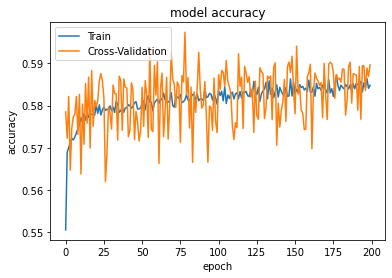

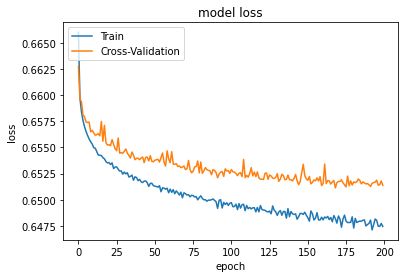

In [71]:
print('Results (lr 0.0001, Adam, relu, 3 hidden layers, 200 epochs):')

# plot test accuracy per epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train','Cross-Validation'],loc='upper left')
plt.show()

#plot test loss per epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train','Cross-Validation'],loc='upper left')
plt.show()

[Text(0, 0.5, 'positive'), Text(0, 1.5, 'negative')]

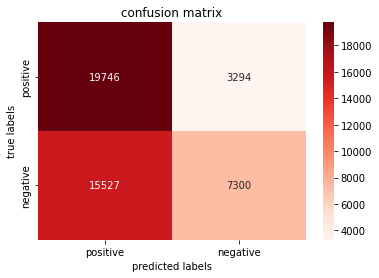

In [72]:
# confusion matrix to see how the model is doing

from sklearn.metrics import confusion_matrix

ax=plt.subplot()
predict_results = model.predict(norm_test)

predict_results = (predict_results > 0.5)
cm = confusion_matrix(y_test, predict_results)

sns.heatmap(cm, annot=True, ax=ax, fmt='d',cmap=plt.cm.Reds)

ax.set_xlabel('predicted labels')
ax.set_ylabel('true labels')
ax.set_title('confusion matrix')
ax.xaxis.set_ticklabels(['positive', 'negative'])
ax.yaxis.set_ticklabels(['positive', 'negative'])

## Hyperparameter Tuning (other models tested)
- learning rate, optimizer, activation function, number of layers and number of epochs

In [66]:
# evaluate model

print('Results lr 0.0001, Adam, relu, 3 hidden layers, 100 epochs')
print('Train split:')
loss, accuracy = model.evaluate(norm_train, y_train, verbose=1)
print('Accuracy: {:5.2f}'.format(accuracy))

print('Test split:')
loss, accuracy = model.evaluate(norm_test, y_test, verbose=1)
print('Accuracy: {:5.2f}'.format(accuracy))

Results lr 0.0001, Adam, relu, 3 hidden layers, 100 epochs
Train split:
5734/5734 [==============================] - 18s 3ms/step - loss: 0.6498 - accuracy: 0.5696
Accuracy:  0.57
Test split:
1434/1434 [==============================] - 4s 3ms/step - loss: 0.6525 - accuracy: 0.5717
Accuracy:  0.57


Results (lr 0.0001, Adam, relu, 3 hidden layers, 100 epochs):


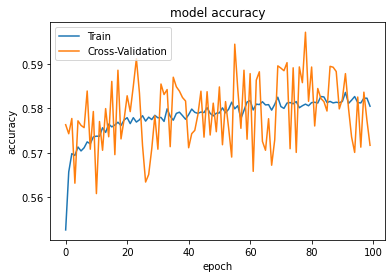

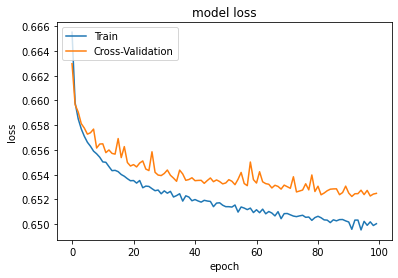

In [67]:
print('Results (lr 0.0001, Adam, relu, 3 hidden layers, 100 epochs):')

# plot test accuracy per epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train','Cross-Validation'],loc='upper left')
plt.show()

#plot test loss per epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train','Cross-Validation'],loc='upper left')
plt.show()

In [62]:
# evaluate model

print('Results lr 0.0001, Adam, relu, 1 hidden layer')
print('Train split:')
loss, accuracy = model.evaluate(norm_train, y_train, verbose=1)
print('Accuracy: {:5.2f}'.format(accuracy))

print('Test split:')
loss, accuracy = model.evaluate(norm_test, y_test, verbose=1)
print('Accuracy: {:5.2f}'.format(accuracy))

Results lr 0.0001, Adam, relu, 1 hidden layer
Train split:
5734/5734 [==============================] - 17s 3ms/step - loss: 0.6559 - accuracy: 0.5650
Accuracy:  0.57
Test split:
1434/1434 [==============================] - 4s 3ms/step - loss: 0.6568 - accuracy: 0.5668
Accuracy:  0.57


In [63]:
# evaluate model

print('Results lr 0.0001, Adam, relu, 1 hidden layer')
print('Train split:')
loss, accuracy = model.evaluate(norm_train, y_train, verbose=1)
print('Accuracy: {:5.2f}'.format(accuracy))

print('Test split:')
loss, accuracy = model.evaluate(norm_test, y_test, verbose=1)
print('Accuracy: {:5.2f}'.format(accuracy))

Results lr 0.0001, Adam, relu, 1 hidden layer
Train split:
5734/5734 [==============================] - 17s 3ms/step - loss: 0.6559 - accuracy: 0.5650
Accuracy:  0.57
Test split:
1434/1434 [==============================] - 4s 3ms/step - loss: 0.6568 - accuracy: 0.5668
Accuracy:  0.57


In [58]:
# evaluate model

print('Results lr 0.0001, Adam, relu, 2 hidden layers')
print('Train split:')
loss, accuracy = model.evaluate(norm_train, y_train, verbose=1)
print('Accuracy: {:5.2f}'.format(accuracy))

print('Test split:')
loss, accuracy = model.evaluate(norm_test, y_test, verbose=1)
print('Accuracy: {:5.2f}'.format(accuracy))

Results lr 0.0001, Adam, relu, 2 hidden layers
Train split:
5734/5734 [==============================] - 17s 3ms/step - loss: 0.6532 - accuracy: 0.5720
Accuracy:  0.57
Test split:
1434/1434 [==============================] - 4s 3ms/step - loss: 0.6550 - accuracy: 0.5734
Accuracy:  0.57


Results (lr 0.0001, Adam, relu, 2 hidden layers):


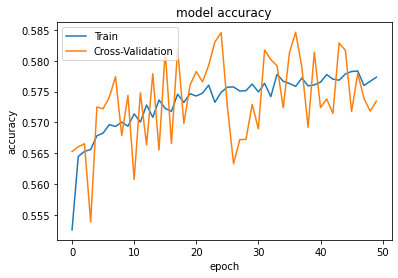

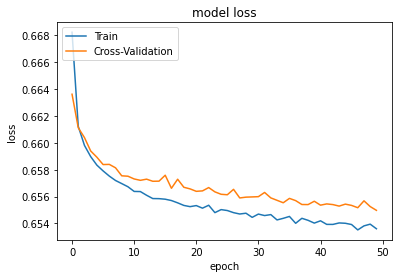

In [59]:
print('Results (lr 0.0001, Adam, relu, 2 hidden layers):')

# plot test accuracy per epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train','Cross-Validation'],loc='upper left')
plt.show()

#plot test loss per epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train','Cross-Validation'],loc='upper left')
plt.show()

In [54]:
# evaluate model

print('Results lr 0.0001, Adam, softmax, 3 hidden layers')
print('Train split:')
loss, accuracy = model.evaluate(norm_train, y_train, verbose=1)
print('Accuracy: {:5.2f}'.format(accuracy))

print('Test split:')
loss, accuracy = model.evaluate(norm_test, y_test, verbose=1)
print('Accuracy: {:5.2f}'.format(accuracy))

Results lr 0.0001, Adam, softmax, 3 hidden layers
Train split:
5734/5734 [==============================] - 18s 3ms/step - loss: 0.6618 - accuracy: 0.5772
Accuracy:  0.58
Test split:
1434/1434 [==============================] - 4s 3ms/step - loss: 0.6628 - accuracy: 0.5789
Accuracy:  0.58


Results (lr 0.0001, Adam, softmax, 3 hidden layers):


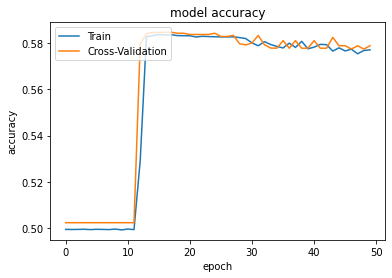

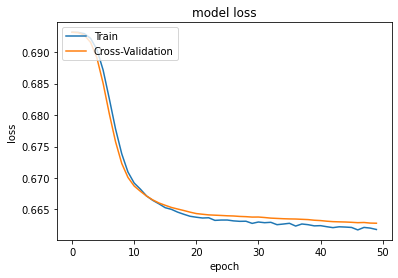

In [55]:
print('Results (lr 0.0001, Adam, softmax, 3 hidden layers):')

# plot test accuracy per epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train','Cross-Validation'],loc='upper left')
plt.show()

#plot test loss per epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train','Cross-Validation'],loc='upper left')
plt.show()

In [50]:
# evaluate model

print('Results lr 0.0001, Adam, sigmoid, 3 hidden layers')
print('Train split:')
loss, accuracy = model.evaluate(norm_train, y_train, verbose=1)
print('Accuracy: {:5.2f}'.format(accuracy))

print('Test split:')
loss, accuracy = model.evaluate(norm_test, y_test, verbose=1)
print('Accuracy: {:5.2f}'.format(accuracy))

Results lr 0.0001, Adam, sigmoid, 3 hidden layers
Train split:
5734/5734 [==============================] - 17s 3ms/step - loss: 0.6585 - accuracy: 0.5656
Accuracy:  0.57
Test split:
1434/1434 [==============================] - 5s 3ms/step - loss: 0.6592 - accuracy: 0.5678
Accuracy:  0.57


Results (lr 0.0001, Adam, sigmoid, 3 hidden layers):


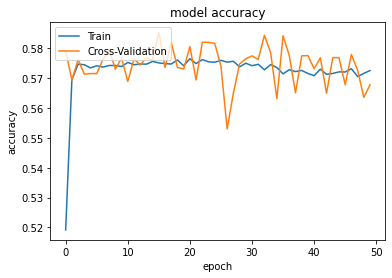

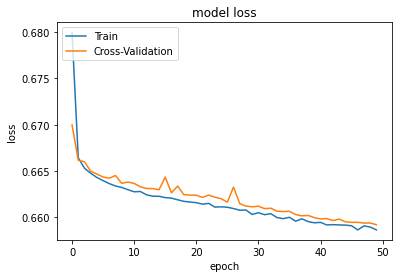

In [51]:
print('Results (lr 0.0001, Adam, sigmoid, 3 hidden layers):')

# plot test accuracy per epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train','Cross-Validation'],loc='upper left')
plt.show()

#plot test loss per epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train','Cross-Validation'],loc='upper left')
plt.show()

In [46]:
# evaluate model

print('Results lr 0.0001, RMSprop, relu, 3 hidden layers')
print('Train split:')
loss, accuracy = model.evaluate(norm_train, y_train, verbose=1)
print('Accuracy: {:5.2f}'.format(accuracy))

print('Test split:')
loss, accuracy = model.evaluate(norm_test, y_test, verbose=1)
print('Accuracy: {:5.2f}'.format(accuracy))

Results lr 0.0001, RMSprop, relu, 3 hidden layers
Train split:
5734/5734 [==============================] - 18s 3ms/step - loss: 0.6512 - accuracy: 0.5745
Accuracy:  0.57
Test split:
1434/1434 [==============================] - 5s 3ms/step - loss: 0.6539 - accuracy: 0.5757
Accuracy:  0.58


Results (lr 0.0001, RMSprop, relu, 3 hidden layers):


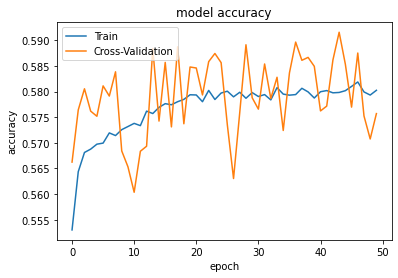

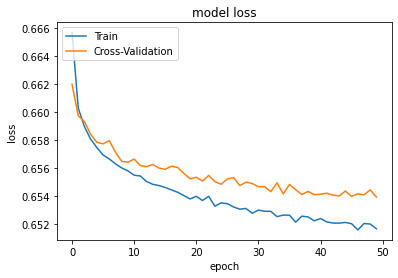

In [47]:
print('Results (lr 0.0001, RMSprop, relu, 3 hidden layers):')

# plot test accuracy per epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train','Cross-Validation'],loc='upper left')
plt.show()

#plot test loss per epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train','Cross-Validation'],loc='upper left')
plt.show()

In [42]:
# evaluate model

print('Results lr 0.0001, SGD, relu, 3 hidden layers')
print('Train split:')
loss, accuracy = model.evaluate(norm_train, y_train, verbose=1)
print('Accuracy: {:5.2f}'.format(accuracy))

print('Test split:')
loss, accuracy = model.evaluate(norm_test, y_test, verbose=1)
print('Accuracy: {:5.2f}'.format(accuracy))

Results lr 0.0001, SGD, relu, 3 hidden layers
Train split:
5734/5734 [==============================] - 18s 3ms/step - loss: 0.6688 - accuracy: 0.5462
Accuracy:  0.55
Test split:
1434/1434 [==============================] - 4s 3ms/step - loss: 0.6693 - accuracy: 0.5462
Accuracy:  0.55


Results (lr 0.0001, SGD, relu, 3 hidden layers):


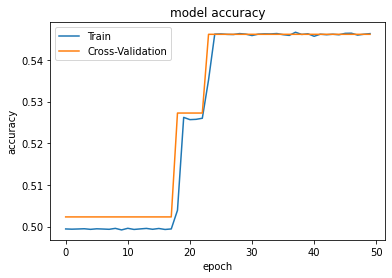

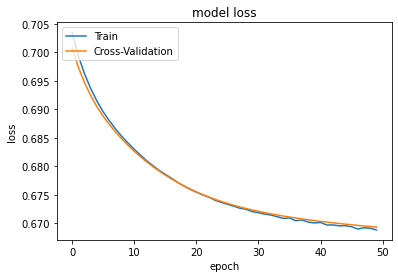

In [43]:
print('Results (lr 0.0001, SGD, relu, 3 hidden layers):')

# plot test accuracy per epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train','Cross-Validation'],loc='upper left')
plt.show()

#plot test loss per epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train','Cross-Validation'],loc='upper left')
plt.show()

In [38]:
# evaluate model

print('Results lr 0.1, Adam, relu, 3 hidden layers')
print('Train split:')
loss, accuracy = model.evaluate(norm_train, y_train, verbose=1)
print('Accuracy: {:5.2f}'.format(accuracy))

print('Test split:')
loss, accuracy = model.evaluate(norm_test, y_test, verbose=1)
print('Accuracy: {:5.2f}'.format(accuracy))

Results lr 0.1, Adam, relu, 3 hidden layers
Train split:
5734/5734 [==============================] - 17s 3ms/step - loss: 0.6934 - accuracy: 0.4994
Accuracy:  0.50
Test split:
1434/1434 [==============================] - 5s 3ms/step - loss: 0.6933 - accuracy: 0.5023
Accuracy:  0.50


Results (lr 0.1, Adam, relu, 3 hidden layers):


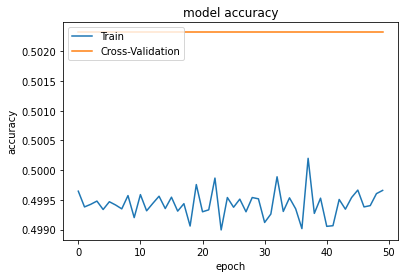

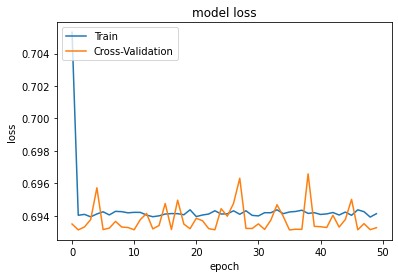

In [39]:
print('Results (lr 0.1, Adam, relu, 3 hidden layers):')

# plot test accuracy per epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train','Cross-Validation'],loc='upper left')
plt.show()

#plot test loss per epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train','Cross-Validation'],loc='upper left')
plt.show()

In [34]:
# evaluate model

print('Results lr 0.01, Adam, relu, 3 hidden layers')
print('Train split:')
loss, accuracy = model.evaluate(norm_train, y_train, verbose=1)
print('Accuracy: {:5.2f}'.format(accuracy))

print('Test split:')
loss, accuracy = model.evaluate(norm_test, y_test, verbose=1)
print('Accuracy: {:5.2f}'.format(accuracy))

Results lr 0.01, Adam, relu, 3 hidden layers
Train split:
5734/5734 [==============================] - 19s 3ms/step - loss: 0.6700 - accuracy: 0.4994
Accuracy:  0.50
Test split:
1434/1434 [==============================] - 5s 3ms/step - loss: 0.6723 - accuracy: 0.5023
Accuracy:  0.50


Results (lr 0.01, Adam, relu, 3 hidden layers):


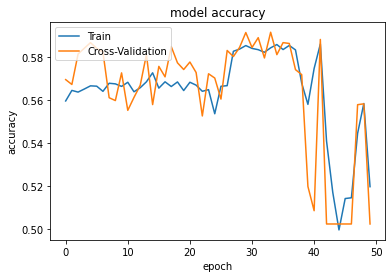

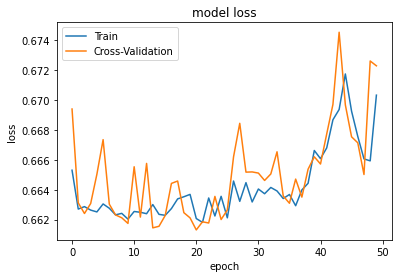

In [35]:
print('Results (lr 0.01, Adam, relu, 3 hidden layers):')

# plot test accuracy per epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train','Cross-Validation'],loc='upper left')
plt.show()

#plot test loss per epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train','Cross-Validation'],loc='upper left')
plt.show()

In [30]:
# evaluate model

print('Results lr 0.001, Adam, relu, 3 hidden layers')
print('Train split:')
loss, accuracy = model.evaluate(norm_train, y_train, verbose=1)
print('Accuracy: {:5.2f}'.format(accuracy))

print('Test split:')
loss, accuracy = model.evaluate(norm_test, y_test, verbose=1)
print('Accuracy: {:5.2f}'.format(accuracy))

Results lr 0.001, Adam, relu, 3 hidden layers
Train split:
5734/5734 [==============================] - 18s 3ms/step - loss: 0.6468 - accuracy: 0.5764
Accuracy:  0.58
Test split:
1434/1434 [==============================] - 5s 3ms/step - loss: 0.6514 - accuracy: 0.5767
Accuracy:  0.58


Results (lr 0.001, Adam, relu, 3 hidden layers):


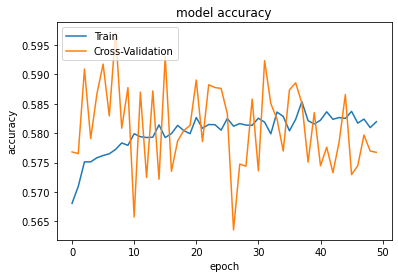

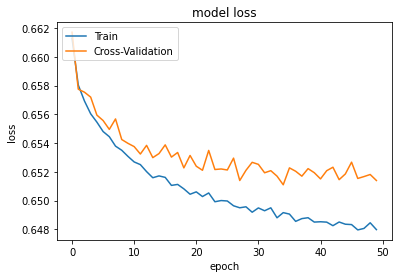

In [31]:
print('Results (lr 0.001, Adam, relu, 3 hidden layers):')

# plot test accuracy per epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train','Cross-Validation'],loc='upper left')
plt.show()

#plot test loss per epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train','Cross-Validation'],loc='upper left')
plt.show()

In [26]:
# evaluate model

print('Results lr 0.0001, Adam, relu, 3 hidden layers')
print('Train split:')
loss, accuracy = model.evaluate(norm_train, y_train, verbose=1)
print('Accuracy: {:5.2f}'.format(accuracy))

print('Test split:')
loss, accuracy = model.evaluate(norm_test, y_test, verbose=1)
print('Accuracy: {:5.2f}'.format(accuracy))

Results lr 0.0001, Adam, relu, 3 hidden layers
Train split:
5734/5734 [==============================] - 18s 3ms/step - loss: 0.6507 - accuracy: 0.5758
Accuracy:  0.58
Test split:
1434/1434 [==============================] - 5s 3ms/step - loss: 0.6530 - accuracy: 0.5771
Accuracy:  0.58


Results (lr 0.0001, Adam, relu, 3 hidden layers):


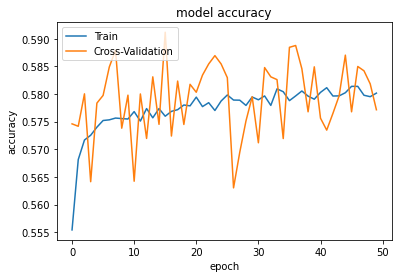

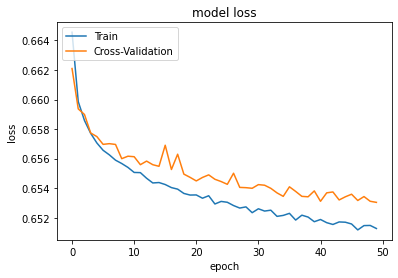

In [27]:
print('Results (lr 0.0001, Adam, relu, 3 hidden layers):')

# plot test accuracy per epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train','Cross-Validation'],loc='upper left')
plt.show()

#plot test loss per epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train','Cross-Validation'],loc='upper left')
plt.show()